# Check emission pairs to see which are missing in construction

In [198]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append("../src/")
sys.path.append("..")

from src.examples.example_setups import setup_stat_scm, setup_ind_scm
from src.utils.sem_utils.emissions import get_emissions_input_output_pairs
from src.utils.sequential_causal_functions import sequentially_sample_model
from src.utils.sem_utils.emissions import fit_sem_emit_fncs, fit_sem_emit_fncs_v2
from numpy.random import seed


seed(seed=0)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


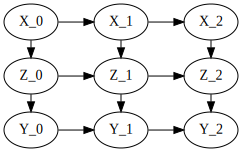

In [229]:
T = 3 # In this example, as in the paper, we consider three time-slices
init_sem, sem, dag_view, dag, exploration_sets, intervention_domain, true_objective_values  = setup_stat_scm(T=3)
# This is just a snapshot of the DAG at hand
dag_view

In [230]:
dag.add_edge("Z_0","X_0")
dag.add_edge("Z_1","X_1")
dag.add_edge("Z_2","X_2")

dag.remove_edge("X_0","Z_0")
dag.remove_edge("X_1","Z_1")
dag.remove_edge("X_2","Z_2")

In [176]:
dag.add_edge("X_0","Y_0")
dag.add_edge("X_1","Y_1")
dag.add_edge("X_2","Y_2")

0

In [231]:

# Number of independent samples (samples here are the time-series on the horizontal) per time-index
D_Obs = sequentially_sample_model(init_sem,
                                sem,
                                total_timesteps=T,
                                sample_count=5, # How many samples we take per node in each time-slice
                                epsilon=None) # If we employ a noise model or not

D_Obs

{'X': array([[-0.18718385,  1.34559536,  2.81495413],
        [ 1.23029068,  2.43267053,  2.04534371],
        [-0.4380743 , -1.69086966, -0.91337931],
        [-0.02818223,  0.40014964,  0.46666686],
        [-1.7262826 , -1.54885646, -1.9506374 ]]),
 'Z': array([[ 1.36079639e+00,  1.99934354e+00,  1.17146526e+00],
        [-1.00951244e-02, -9.70846048e-01, -2.26152826e+00],
        [-6.41777977e-02,  5.14727779e+00,  6.74454325e+00],
        [ 1.33105500e+00,  1.36695265e+00,  1.63130045e+00],
        [ 3.98952593e+00,  9.15839370e+00,  1.52842644e+01]]),
 'Y': array([[-2.7065599 , -4.374889  , -4.77284705],
        [-1.70682603, -0.24118898, -2.50766016],
        [ 0.38162977, -0.48095265, -1.4798827 ],
        [-1.37062265, -2.46167665, -4.25696293],
        [-1.42874866, -2.29698541, -3.54527713]])}

In [250]:
f = fit_sem_emit_fncs_v2(dag, D_Obs)

In [251]:
f

{0: {('Z', 0, 'X'): <GPy.models.gp_regression.GPRegression at 0x7fbdd0be5410>,
  ('Z', 1, 'Y'): <GPy.models.gp_regression.GPRegression at 0x7fbdd0c02310>,
  (None, 'Z'): KernelDensity()},
 1: {('Z', 0, 'X'): <GPy.models.gp_regression.GPRegression at 0x7fbdd0c10310>,
  ('Z', 1, 'Y'): <GPy.models.gp_regression.GPRegression at 0x7fbdd0c02a10>},
 2: {('Z', 0, 'X'): <GPy.models.gp_regression.GPRegression at 0x7fbdd0c02e10>,
  ('Z', 1, 'Y'): <GPy.models.gp_regression.GPRegression at 0x7fbd712503d0>}}

# Convert to adjacency matrix and get all relationships from that

In [112]:
from networkx.linalg.graphmatrix import adjacency_matrix
from networkx.convert import to_dict_of_lists
import numpy as np
from scipy.linalg import block_diag 
from src.utils.dag_utils.adjacency_matrix_utils import get_emit_and_trans_adjacency_mats

In [ ]:
def func(G):
    # Standard
    A = adjacency_matrix(G)
    # In array form 
    AA = np.asarray(A.todense())
    # List of all nodes in G
    nodes = np.array(dag.nodes())
    # List of all leaf/source nodes/vertices in G (confounders are not included)
    sources = nodes[~AA.sum(axis=0).astype(bool)].tolist()

    # Get all input-output tuples

In [245]:
nodes = np.array(dag.nodes()).astype(str)
E_mat,T_mat, T = get_emit_and_trans_adjacency_mats(dag)
E_mat

array([[0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 1, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 0]])

In [240]:
E_mat.sum(axis=0).astype(bool)

array([ True, False,  True,  True, False,  True,  True, False,  True])

In [247]:
nodes.tolist()

['X_0', 'Z_0', 'Y_0', 'X_1', 'Z_1', 'Y_1', 'X_2', 'Z_2', 'Y_2']

In [208]:
T_mat.sum(axis=0).astype(bool)

array([False, False, False,  True,  True,  True,  True,  True,  True])

In [243]:
[1,2,3] | [2]

TypeError: unsupported operand type(s) for |: 'list' and 'list'

In [205]:
dag.in_degree('X_1')

1

In [171]:
to_dict_of_lists(dag)

{'X_0': ['X_1'],
 'Z_0': ['Y_0', 'Z_1', 'X_0'],
 'Y_0': ['Y_1'],
 'X_1': ['X_2'],
 'Z_1': ['Y_1', 'Z_2', 'X_1'],
 'Y_1': ['Y_2'],
 'X_2': [],
 'Z_2': ['Y_2', 'X_2'],
 'Y_2': []}